# Two-Fluids SBN with axicon

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
from scipy import *
from numpy import *
from pylab import *
import arrayfire as af
from core_libs.bindings import *
from core_libs.af_loader import *
from core_libs.functions_for_initial_conditions import *
from core_libs.functions_for_fit import *
from core_libs.turbulence_methods import *
from scipy import fftpack
from scipy import special
from matplotlib.pyplot import *
from scipy import optimize
import scipy as sp
from IPython.display import Markdown, display
from scipy.special import jv, jn
import enlighten

import warnings
warnings.filterwarnings('ignore')


def printmd(string, color=None):
    colorstr = "#### <span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))
    

# <font color='blue'>System parameters - configuration</font>

#### <span style='color:green'>$P_{fluid}=$48.8$\mu W$</span>

#### <span style='color:red'>$P_{obs}=$50.17006802721088$\mu W$</span>

#### <span style='color:blue'>$c_s=$0.0037</span>

#### <span style='color:blue'>$v=$0.003</span>

#### <span style='color:blue'>$v/c_s=$0.8253</span>

#### <span style='color:blue'>$\xi=$9.78$\mu m$</span>

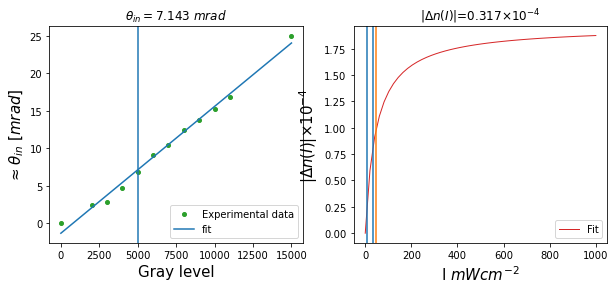

In [51]:
#%matplotlib widget
%matplotlib inline

R = ((2.36-1)/(2.36+1))**2.0
T = 1 - R

#########################################################################################################
#Velocity of the fluid
GL = 5000

#Scaling factor of the power meter
power_meter_factor = 1.34+1.6*0

P_green_beam = 48.8 #muW
P_green_beam_corrected = power_meter_factor*P_green_beam
w = 619.5e-4 #cm

#Red beam parameters
P_red_beam = 50.2*0+60.0 #muW
d_bessel = 121.6e-4 #cm

#########################################################################################################

P_green_beam_corrected *= T
P_red_beam *= T




I_fluid = P_green_beam_corrected*1e-3*2/(np.pi*w**2.0)

r_bessel = d_bessel/2.0
I_defect = P_red_beam*1e-3/(np.pi*r_bessel**2.0)

fig = plt.figure(figsize=(10, 4))

rows = 1
columns = 2

grid = plt.GridSpec(rows, columns, wspace = .2, hspace = .15)

plt.subplot(grid[0, 0])

GL_to_load = [0, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 15000]
angle = [0, 0.00244017, 0.00280785, 0.00476556, 0.00679314, 0.0090616, 0.01050736, 0.01238871, 0.013732, 0.01519613, 0.01677856, 0.02503264]


popt_x_ve, pcov_x = sp.optimize.curve_fit(linear_fit, GL_to_load, angle, p0=[0.001, 0.0])

plt.title("$\\theta_{in}=$" + str(np.round(linear_fit(np.array(GL), *popt_x_ve)/(1e-3),3)) + " $mrad$")
plt.plot(GL_to_load, np.array(angle)/(1e-3), linewidth=0, marker="o", markersize=4, color="tab:green", label="Experimental data")
plt.plot(GL_to_load, linear_fit(np.array(GL_to_load), *popt_x_ve)/(1e-3), label="fit")
plt.xlabel("Gray level", fontsize=15)
plt.ylabel("$\\approx\\theta_{in}$ $[mrad]$", fontsize=15)
plt.axvline(x=GL)

plt.legend(loc=0)   

plt.subplot(grid[0, 1])

N_rings_level_2 = [0, 1, 1, 2, 4, 6, 6, 7, 7]
max_or_minimum_level_2 = [1, 0, 1, 1, 0, 0, 1, 1, 1]

delta_phi_level_2 = np.zeros(len(N_rings_level_2))

for i in range(len(delta_phi_level_2)):
    if max_or_minimum_level_2[i]==1:
        delta_phi_level_2[i] = 2.0*N_rings_level_2[i]*np.pi
    else:
        delta_phi_level_2[i] = 2.0*(N_rings_level_2[i]-1)*np.pi
        
k0 = 2.0*np.pi/(532e-9) 
L = 20e-3
delta_n_level_2 = delta_phi_level_2/(k0*L)

power_to_load_level_2 = [0.553, 2.02, 5.86, 12.72, 29.6, 78.1, 192, 512, 961]
intensities_level_2 = 2.0*np.array(power_to_load_level_2)*power_meter_factor*1e-3/(np.pi*(0.0245)**2.0)

intensities_level_2 *= T

delta_n_params, pcov_x = sp.optimize.curve_fit(delta_n_f, intensities_level_2, delta_n_level_2, p0=[1e-4,25])



plt.title("|$\Delta n(I)$|=" + str(np.round(delta_n_f(I_fluid, *delta_n_params)/(1e-4),3)) + "$\\times 10^{-4}$")

I_theo = np.linspace(0, 1000)
plt.plot(I_theo, delta_n_f(I_theo, *delta_n_params)/1e-4, linewidth=1, label='Fit', color="tab:red")
plt.axvline(x=I_fluid)
plt.axvline(x=70.840/2)
plt.axvline(x=delta_n_params[-1], color="tab:orange")
plt.xlabel("I $mWcm^{-2}$", fontsize=15)
plt.ylabel("|$\Delta n(I)$|$\\times 10^{-4}$", fontsize=15)
plt.legend(loc=0)

plt.tight_layout()

ne = 2.36
k0 = 2.0*np.pi/(532e-9)
cs = np.sqrt(delta_n_f(I_fluid, *delta_n_params)/ne)
fluid_velocity = linear_fit(np.array(GL), *popt_x_ve)/ne
healing_length = 1.0/(ne*k0*cs)

printmd("$P_{fluid}=$" + str(P_green_beam) + "$\mu W$", color="green")
printmd("$P_{obs}=$" + str(P_red_beam) + "$\mu W$", color="red")

printmd("$c_s=$" + str(np.round(cs,4)), color="blue")
printmd("$v=$" + str(np.round(fluid_velocity,4)), color="blue")
printmd("$v/c_s=$" + str(np.round(fluid_velocity/cs,4)), color="blue")

printmd("$\\xi=$" + str(np.round(healing_length/(1e-6),2)) + "$\\mu m$", color="blue")

# <font color='blue'>Calculate simulation parameters</font>

In [52]:
#simulation beam power
If1 = I_fluid/I_fluid #mw/cm^-2 fluid beam
If2 = I_defect/I_fluid #mw/cm^-2 defect
Isat = delta_n_params[-1]/I_fluid #mw/cm^-2

#light fluid wavelength
lf=532*10**-9

#k_fluid
kf = (2*pi)/lf

#parameters of the crystal
ne = 2.36 #index of refraction n_e
r33 = 235*10**-12 #pm/V
#Biasing electric Field
E0 = 1400*10**2 # V/m

#maximum index variation
#delta_n_max = 0.5*ne**3*r33*E0
delta_n_max = delta_n_params[0]
delta_n = delta_n_f(I_fluid, *delta_n_params)


#absorption
alpha = 100 /(delta_n_max * kf) #1.319 cm^-2
gamma = 1

#healing length
hl = 1/(kf*sqrt(ne*delta_n))

#transverse direction scaling factor
factor_t = kf*sqrt(ne*delta_n_max)

#propagation direction scaling factor
factor_z = kf*delta_n_max


##################################################
#Crystal Size
lx = 2.5*10**-3
ly = 2.5*10**-3
lz = 20*10**-3

#in adimensional units
lx_sim = factor_t*lx
ly_sim = factor_t*ly
lz_sim = factor_z*lz

##################################################


Vmax = -1.0*10**-4/delta_n
vel_max = 1/(sqrt(ne)*sqrt(delta_n))

print("I_fluid -> " + str(I_fluid))
print("I_obs -> " + str(I_defect))
print("I_sat -> " + str(Isat*I_fluid))
print("delta_n -> " + str(delta_n))
print("delta_n_max -> " + str(delta_n_max))
print("lx -> " + str(lx_sim))
print("ly -> " + str(ly_sim))
print("lz -> " + str(lz_sim))
print("V_max -> "+ str(Vmax))
print('vel_max - > ' + str(vel_max))
print('healing length - > ' + str(hl))

I_fluid -> 9.07017280731726
I_obs -> 432.00389119780476
I_sat -> 47.01351228990546
delta_n -> 3.1736812864230024e-05
delta_n_max -> 0.00019623853442252335
lx -> 635.4134334020981
ly -> 635.4134334020981
lz -> 46.35349910473888
V_max -> -3.150915009260686
vel_max - > 115.54797611816015
healing length - > 9.783496791765755e-06


# <font color='blue'>Create simulation mesh</font>

Define the simulation box parameters

In [53]:
#number of transversal dimensions (only working 1 and 2, necessary for plotting)
dims = 2

#Number of points in x,y transversal dimensions
Nx = 512
Ny = 512

#do not change Nt, Nz
Nt = 1 
Nz = 1

#spatial steps
dx = lx_sim / Nx
dy = ly_sim / Ny
dt = 1.
print('dx->',dx,'dy->',dy)

#integration parameters

stride = 50
dz = 0.05 #.2
total_steps = int(lz_sim/(stride*dz))
print(total_steps)

#define a directory to save
saveDir = r".turbulence_photorefractive_analytical"

dx-> 1.241041862113473 dy-> 1.241041862113473
18


# <font color='green'>Create simulation initial conditions</font>

In [54]:
def droplet_2d(x_af, y_af, defect_power, defect_intensity_normalization, x0, y0, d1, d2, kz_times_z, factor_t):
   
    np_array =  (jn(0, 2.4048*(np.sqrt((x_af-x0)**2.0 + (y_af-y0)**2.0))/d1 ))**1.0 
    np_array +=  (jn(0, 2.4048*(np.sqrt((x_af-x0)**2.0 + (y_af-y0)**2.0))/d2 ))**1.0 
    np_array = np_array.astype(np.complex128)
    np_array *= np.exp(1j*kz_times_z)
    
    x_max = np.max(x_af)/factor_t*1e3
    y_max = np.max(y_af)/factor_t*1e3
    
    d_x = (x_af[1,0]-x_af[0,0])
    d_y = (y_af[0,1]-y_af[0,0])
    
    d_x *= 5.0/x_max
    d_y *= 5.0/y_max
    
    norm = np.sum(np.abs(np_array)**2.0)*d_x*d_y/factor_t/factor_t*1e4
    
    I_defect = defect_power/norm
    
    I_defect_normalized = I_defect/defect_intensity_normalization
    
    return af.to_array(np.sqrt(I_defect_normalized)*np_array)


In [55]:
#Simulation parameters

waist_sim = w*1e-2*factor_t

#dd = 115.3*10**-6*factor_t #bessel
#dd2 = 239*10**-6*factor_t #bessel

d_besse_1 = 91.9e-4
d_besse_2 = 179.4e-4

dd1 = d_besse_1*1e-2*factor_t/2.0
dd2 = d_besse_2*1e-2*factor_t/2.0

#cs = np.sqrt(1/Isat)
theta = fluid_velocity*ne
vx = theta/ne/np.sqrt(ne*delta_n)
cs = np.sqrt(delta_n/ne)
gamma = 1


print("vx = " + str(vx))
print("vx/cs = " + str(theta/ne/cs))
print("bessel diameter = " + str(dd1), dd2)

my_simulation = simulation_config(dims, Nx, Ny, Nt, Nz, total_steps, 
                                  stride,dx,dy,dz,dt,0,0, 
                                  alpha, Isat, gamma, saveDir)

#Gaussian field - fluid
my_simulation.initial_condition.add_field(gaussian_2d_field(my_simulation.x_af, 
                                                            my_simulation.y_af,
                                                            np.sqrt(If1),
                                                            waist_sim, 
                                                            Nx*dx/2,
                                                            Ny*dy/2,
                                                            vx,
                                                            0))

#Noise
my_simulation.initial_condition.add_field(whitenoise_2d_field(my_simulation.x_af, 0.2))

#Axicon - optical defect
my_simulation.initial_condition2.add_field(droplet_2d(my_simulation.x_af,
                                                     my_simulation.y_af, 
                                                     P_red_beam*1e-3,
                                                     I_fluid,
                                                     my_simulation.Nx*dx/2,
                                                     my_simulation.Ny*dy/2, 
                                                     dd1,
                                                     dd2,
                                                     0,
                                                     factor_t))


#how many
number_nl_numbers = 0
#(g, power)
nl_numbers = []
my_simulation.number_nl_numbers = number_nl_numbers

#define the nonlinearities of type vector
#how many
number_nl_vectors = 0
nl_vectors=[]
my_simulation.number_nl_vectors = number_nl_vectors

vx = 0.34971672512264934
vx/cs = 0.8253314712894524
bessel diameter = 11.678898905930566 22.798633990467284


In [56]:

input_beam_profile = np.transpose(np.abs(my_simulation.initial_condition.np_array)**2.0)

print("P_measured: ", P_green_beam_corrected)
print("P_numerical: ", np.sum(input_beam_profile)*dx*dy/factor_t/factor_t*1e4*I_fluid/(1e-3))
print("\n")
input_axicon_size = np.transpose(np.abs(my_simulation.initial_condition2.np_array)**2.0)
print("P_measured: ", P_red_beam)
print("P_numerical: ", 4*np.sum(input_axicon_size)*dx*dy/factor_t/factor_t*1e4*I_fluid*1e3)
print("\n")
print(I_fluid)
print(Isat)

P_measured:  54.67868480725623
P_numerical:  62.16475618480349


P_measured:  50.17006802721088
P_numerical:  49.97428258260092


9.07017280731726
5.183309435072487


# <font color='blue'>Test simulation initial conditions</font>

3.464147362874908


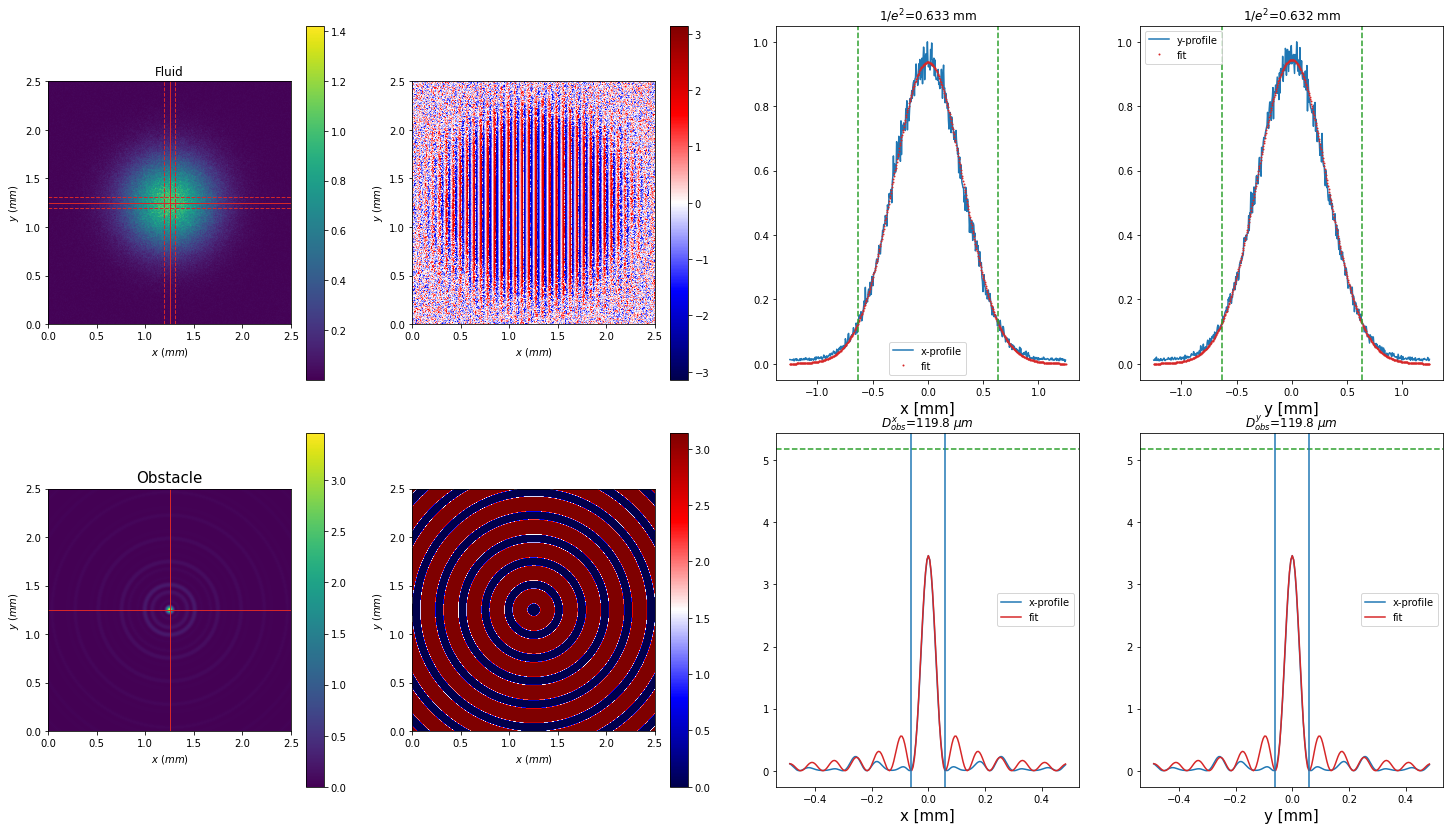

In [57]:
#%matplotlib widget
%matplotlib inline

######################### Gausian

extent_general = [0, Nx*dx/factor_t/(1e-3), 0, Ny*dy/factor_t/(1e-3)]

input_beam_profile = np.transpose(np.abs(my_simulation.initial_condition.np_array)**2.0)
phase_input_beam = np.transpose(np.arctan2(np.imag(my_simulation.initial_condition.np_array), np.real(my_simulation.initial_condition.np_array)))


y_shape, x_shape = np.shape(input_beam_profile)

dx_units = 1440 / x_shape
dy_units = 1080 / y_shape

x_center_4f = 256
y_center_4f = 256

width_mean = 12

profile_x = input_beam_profile[(y_center_4f-width_mean):(y_center_4f+width_mean), :]
profile_y = input_beam_profile[:, (x_center_4f-width_mean):(x_center_4f+width_mean)]
profile_x = np.mean(profile_x, axis=0)
profile_y = np.mean(profile_y, axis=1)


# profile_x = input_beam_profile[y_center, :]
# profile_y = input_beam_profile[:, x_center]


profile_x = profile_x/np.max(profile_x)
profile_y = profile_y/np.max(profile_y)


x_array = np.array(my_simulation.x_af)[:, y_center_4f] - np.array(my_simulation.x_af)[x_center_4f, y_center_4f]
y_array = np.array(my_simulation.y_af)[x_center_4f, :] - np.array(my_simulation.y_af)[x_center_4f, y_center_4f]

popt_x, pcov_x = sp.optimize.curve_fit(gaus, x_array, profile_x, p0=[1,0,30.0])

popt_y, pcov_y = sp.optimize.curve_fit(gaus, y_array, profile_y, p0=[1,0,30.0])



fig = plt.figure(figsize=(25, 14))

rows = 2
columns = 4

grid = plt.GridSpec(rows, columns, wspace = .2, hspace = .15)

plt.subplot(grid[0, 0])
plt.title("Fluid")
plt.imshow(input_beam_profile, extent=extent_general)
plt.colorbar()
plt.xlabel(r"$x$ $(mm)$")
plt.ylabel(r"$y$ $(mm)$")

plt.axvline(x=(x_center_4f)*dx/factor_t/(1e-3), color="tab:red", linewidth=1)
plt.axvline(x=(x_center_4f - width_mean)*dx/factor_t/(1e-3), color="tab:red", linewidth=1, linestyle="--")
plt.axvline(x=(x_center_4f + width_mean)*dx/factor_t/(1e-3), color="tab:red", linewidth=1, linestyle="--")

plt.axhline(y=(y_center_4f)*dy/factor_t/(1e-3), color="tab:red", linewidth=1)
plt.axhline(y=(y_center_4f - width_mean)*dy/factor_t/(1e-3), color="tab:red", linewidth=1, linestyle="--")
plt.axhline(y=(y_center_4f + width_mean)*dy/factor_t/(1e-3), color="tab:red", linewidth=1, linestyle="--")

plt.subplot(grid[0, 1])
plt.imshow(phase_input_beam, cmap="seismic", extent=extent_general)
plt.colorbar()
plt.xlabel(r"$x$ $(mm)$")
plt.ylabel(r"$y$ $(mm)$")

plt.subplot(grid[0, 2])
plt.title("$1/e^2$=" + str(np.round(popt_x[-1]/factor_t/(1e-3),3)) + " mm")
plt.plot(x_array/factor_t/(1e-3), profile_x, label="x-profile", color="tab:blue")
plt.plot(x_array/factor_t/(1e-3), gaus(x_array, *popt_x),'ro:', linewidth=0, markersize=1, label='fit', color="tab:red")
plt.legend(loc=0)
plt.xlabel("x [mm]", fontsize=15)

plt.axvline(x=(popt_x[-1] + popt_x[1])/factor_t/(1e-3), color="tab:green", linestyle="--")
plt.axvline(x=-(popt_x[-1] + popt_x[1])/factor_t/(1e-3), color="tab:green", linestyle="--")

plt.subplot(grid[0, 3])
plt.title("$1/e^2$=" + str(np.round(popt_y[-1]/factor_t/(1e-3),3)) + " mm")
plt.plot(y_array/factor_t/(1e-3), profile_y, label="y-profile", color="tab:blue")
plt.plot(y_array/factor_t/(1e-3), gaus(y_array, *popt_y),'ro:', linewidth=0, markersize=1, label='fit', color="tab:red")
plt.legend(loc=0)
plt.xlabel("y [mm]", fontsize=15)

plt.axvline(x=(popt_y[-1] + popt_y[1])/factor_t/(1e-3), color="tab:green", linestyle="--")
plt.axvline(x=-(popt_y[-1] + popt_y[1])/factor_t/(1e-3), color="tab:green", linestyle="--")



#######################          Axicon
input_axicon_size = np.transpose(np.abs(my_simulation.initial_condition2.np_array)**2.0)
phase_axicon = np.transpose(np.arctan2(np.imag(my_simulation.initial_condition2.np_array), np.real(my_simulation.initial_condition2.np_array)))

axicon_max = np.max(input_axicon_size)

y_shape, x_shape = np.shape(input_axicon_size)


x_center_4f = 256
y_center_4f = 256

fit_width = 100

x_array = np.array(my_simulation.x_af)[:, y_center_4f] - np.array(my_simulation.x_af)[x_center_4f, y_center_4f]
y_array = np.array(my_simulation.y_af)[x_center_4f, :] - np.array(my_simulation.y_af)[x_center_4f, y_center_4f]

profile_x_4f_input_axicon_size = input_axicon_size[y_center_4f, :]
profile_y_4f_input_axicon_size = input_axicon_size[:, x_center_4f]

profile_x_4f_input_axicon_size_cutted = profile_x_4f_input_axicon_size[(x_center_4f-fit_width):((x_center_4f+fit_width))]
profile_y_4f_input_axicon_size_cutted = profile_y_4f_input_axicon_size[(y_center_4f-fit_width):((y_center_4f+fit_width))]

profile_x_4f_input_axicon_size_cutted = profile_x_4f_input_axicon_size_cutted/np.max(profile_x_4f_input_axicon_size_cutted)
profile_y_4f_input_axicon_size_cutted = profile_y_4f_input_axicon_size_cutted/np.max(profile_y_4f_input_axicon_size_cutted)

x_array_cutted_4f = x_array[(x_center_4f-fit_width):((x_center_4f+fit_width))]
y_array_cutted_4f = y_array[(y_center_4f-fit_width):((y_center_4f+fit_width))]

popt_x_input_4f, pcov_x_input = sp.optimize.curve_fit(bessel_function, x_array_cutted_4f, profile_x_4f_input_axicon_size_cutted, p0=[0, 10.0])
popt_y_input_4f, pcov_y_input = sp.optimize.curve_fit(bessel_function, y_array_cutted_4f, profile_y_4f_input_axicon_size_cutted, p0= [0, popt_x_input_4f[-1]])

######################################################################################################################################################

plt.subplot(grid[1, 0])
plt.title("Obstacle", fontsize=15)
plt.imshow(input_axicon_size, extent=extent_general)
plt.colorbar()
plt.axvline(x=x_center_4f*dx/factor_t/(1e-3), color="tab:red", linewidth=1)
plt.axhline(y=y_center_4f*dy/factor_t/(1e-3), color="tab:red", linewidth=1)
plt.xlabel(r"$x$ $(mm)$")
plt.ylabel(r"$y$ $(mm)$")

plt.subplot(grid[1, 1])

plt.imshow(phase_axicon, cmap="seismic", extent=extent_general)
plt.colorbar()
plt.xlabel(r"$x$ $(mm)$")
plt.ylabel(r"$y$ $(mm)$")


plt.subplot(grid[1, 2])
plt.title("$D^x_{obs}$=" + str(2.0*np.round(popt_x_input_4f[-1]/factor_t/(1e-6),1)) + " $\\mu m$")
plt.plot(x_array_cutted_4f/factor_t/(1e-3), axicon_max*profile_x_4f_input_axicon_size_cutted, label="x-profile", color="tab:blue")
plt.plot(x_array_cutted_4f/factor_t/(1e-3), axicon_max*bessel_function(x_array_cutted_4f, *popt_x_input_4f), label='fit', color="tab:red")
plt.legend(loc=0)
plt.xlabel("x [mm]", fontsize=15)
plt.axhline(y=Isat, linestyle="--", color="tab:green")

plt.axvline(x=popt_x_input_4f[-1]/factor_t/(1e-3))
plt.axvline(x=-popt_x_input_4f[-1]/factor_t/(1e-3))


plt.subplot(grid[1, 3])
plt.title("$D^y_{obs}$=" + str(2.0*np.round(popt_y_input_4f[-1]/factor_t/(1e-6),1)) + " $\\mu m$")
plt.plot(y_array_cutted_4f/factor_t/(1e-3), axicon_max*profile_y_4f_input_axicon_size_cutted, label="x-profile", color="tab:blue")
plt.plot(y_array_cutted_4f/factor_t/(1e-3), axicon_max*bessel_function(y_array_cutted_4f, *popt_y_input_4f), label='fit', color="tab:red")
plt.legend(loc=0)
plt.xlabel("y [mm]", fontsize=15)
plt.axhline(y=Isat, linestyle="--", color="tab:green")

plt.axvline(x=popt_y_input_4f[-1]/factor_t/(1e-3))
plt.axvline(x=-popt_y_input_4f[-1]/factor_t/(1e-3))

plt.tight_layout()

print(np.max(input_axicon_size))


# <font color='blue'>Generate Configuration file</font>

In [58]:
my_simulation.gen_config_file(nl_numbers,nl_vectors)

**Configuring Mesh:
Config folder already exists, skipping mkdir
Configuration file created!
**Configuring Initial Conditions
Initial condition file created!
**Configuring nonlinearities:
Nonlinearities configuration files created!


# <font color='blue'>Set device to compute</font>

In [59]:
af.device.set_device(0)
af.device.device_info()

{'device': 'GeForce_GTX_TITAN',
 'backend': 'OpenCL',
 'toolkit': 'NVIDIA CUDA',
 'compute': '1.2'}

# <font color='blue'>Run Simulation</font>

Having the engine built previously and added to the folder we can call from the command line to execute it.

Options:

First argument corresponds to backend: 1 - CPU; 2 - OpenCl; 3 - CUDA;

Second argument corresponds to device: 0 - #number of devices available to choose the device

In [60]:
%%cmd
hibpm_run.exe 2 0 

Microsoft Windows [Version 10.0.19044.1706]
(c) Microsoft Corporation. All rights reserved.

(LAB_env) E:\Nonlinear_Optics_LAB\LAB_Repository\Tiago_Code\SBN>hibpm_run.exe 2 0 
Running info
Creating a mesh for our problem 
---Mesh created--- 
---scalar field created--- 
---start--- 
Stride 0 of 18 aqui:0.05
aqui
update Stride 1 of 18 aqui:0.05
aqui
update Stride 2 of 18 aqui:0.05
aqui
update Stride 3 of 18 aqui:0.05
aqui
update Stride 4 of 18 aqui:0.05
aqui
update Stride 5 of 18 aqui:0.05
aqui
update Stride 6 of 18 aqui:0.05
aqui
update Stride 7 of 18 aqui:0.05
aqui
update Stride 8 of 18 aqui:0.05
aqui
update Stride 9 of 18 aqui:0.05
aqui
update Stride 10 of 18 aqui:0.05
aqui
update Stride 11 of 18 aqui:0.05
aqui
update Stride 12 of 18 aqui:0.05
aqui
update Stride 13 of 18 aqui:0.05
aqui
update Stride 14 of 18 aqui:0.05
aqui
update Stride 15 of 18 aqui:0.05
aqui
update Stride 16 of 18 aqui:0.05
aqui
update Stride 17 of 18 aqui:0.05
aqui
update Total elapsed time 	5937
ArrayFire v3.6.4 (

In [61]:
Isat

5.183309435072487

# <font color='blue'>Load data</font>

In [62]:
#load the simulation mesh - here we use the data generated , deprecating the previous generated data; 
#they are equivalent, but this way you can adapt the same codes to simulations generated from pure c++ simulations

#load the simulation mesh
my_mesh = mesh(saveDir+"/")

#load the data from data folder
#stride between consecutive loaded files
stride_read = 1

simulation_data,zs = load_data_folder(saveDir+"/gnlse_field/",my_mesh,stride_read)
simulation_data2,zs = load_data_folder(saveDir+"/gnlse_field2/",my_mesh,stride_read)

# <font color='blue'>Plot results</font>

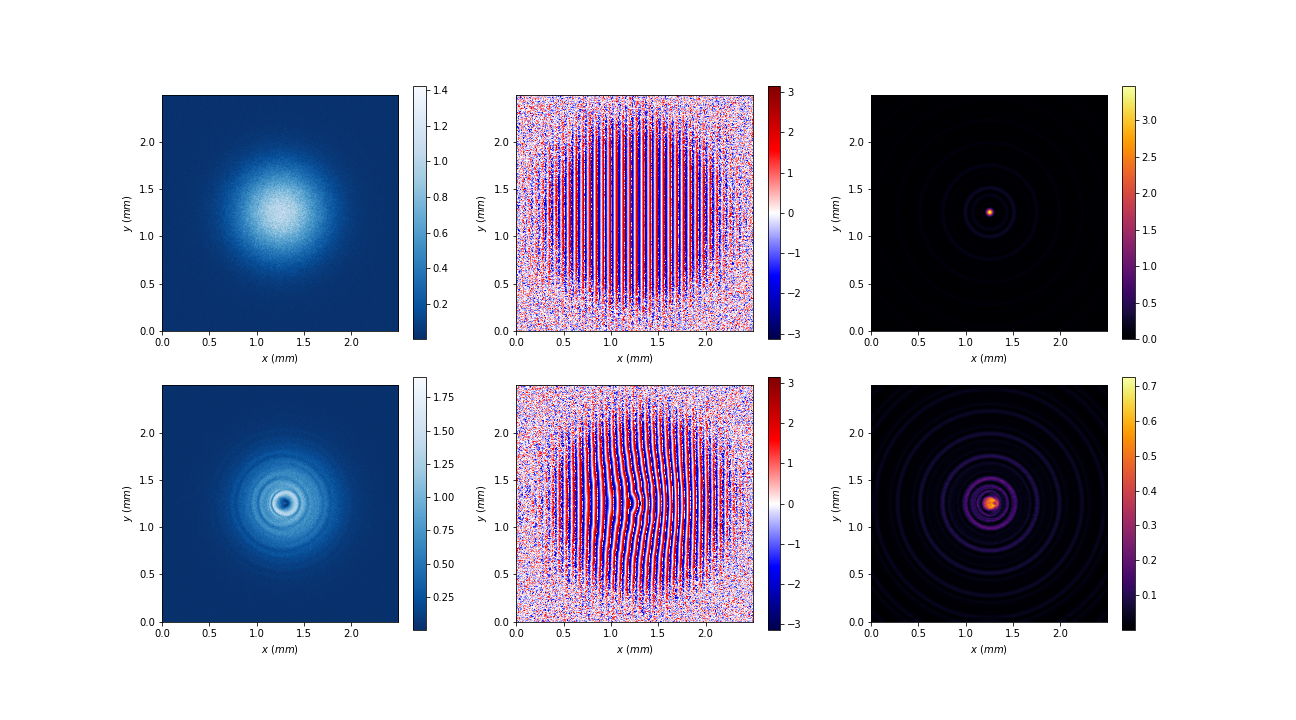

In [65]:
%matplotlib widget
#%matplotlib inline

fig = plt.figure(figsize=(18, 10))

rows = 2
columns = 3

grid = plt.GridSpec(rows, columns, wspace = .2, hspace = .15)

extent_general = [0, my_mesh.lx/factor_t/(1e-3),0,my_mesh.ly/factor_t/(1e-3)]

plt.subplot(grid[0, 0])

im = imshow(transpose(abs(simulation_data[0])**2), origin = "lower", extent = extent_general, 
       aspect = "equal", cmap = 'Blues_r')
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
colorbar(im)

plt.subplot(grid[0, 1])
phase = np.arctan2(np.imag(simulation_data[0]), np.real(simulation_data[0]))
im = imshow(transpose(phase), origin = "lower", extent = extent_general, 
       aspect = "equal", cmap = 'seismic')
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
colorbar(im)

plt.subplot(grid[0, 2])
im1 = imshow(transpose(abs(simulation_data2[0])**2), origin = "lower", extent = extent_general, 
       aspect = "equal", cmap = cm.inferno)
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
colorbar(im1)

plt.subplot(grid[1, 0])
im = imshow(transpose(abs(simulation_data[-1])**2), origin = "lower", extent = extent_general, 
       aspect = "equal", cmap = 'Blues_r')
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
colorbar(im)

plt.subplot(grid[1, 1])
phase = np.arctan2(np.imag(simulation_data[-1]), np.real(simulation_data[-1]))
im = imshow(transpose(phase), origin = "lower",extent = extent_general, 
       aspect = "equal", cmap = 'seismic')
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
colorbar(im)

plt.subplot(grid[1, 2])
im1 = imshow(transpose(abs(simulation_data2[-1])**2), origin = "lower", extent = extent_general, 
       aspect = "equal", cmap = cm.inferno)
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
colorbar(im1)

fig.tight_layout()


# <font color='blue'>Plot results - arround the defect</font>

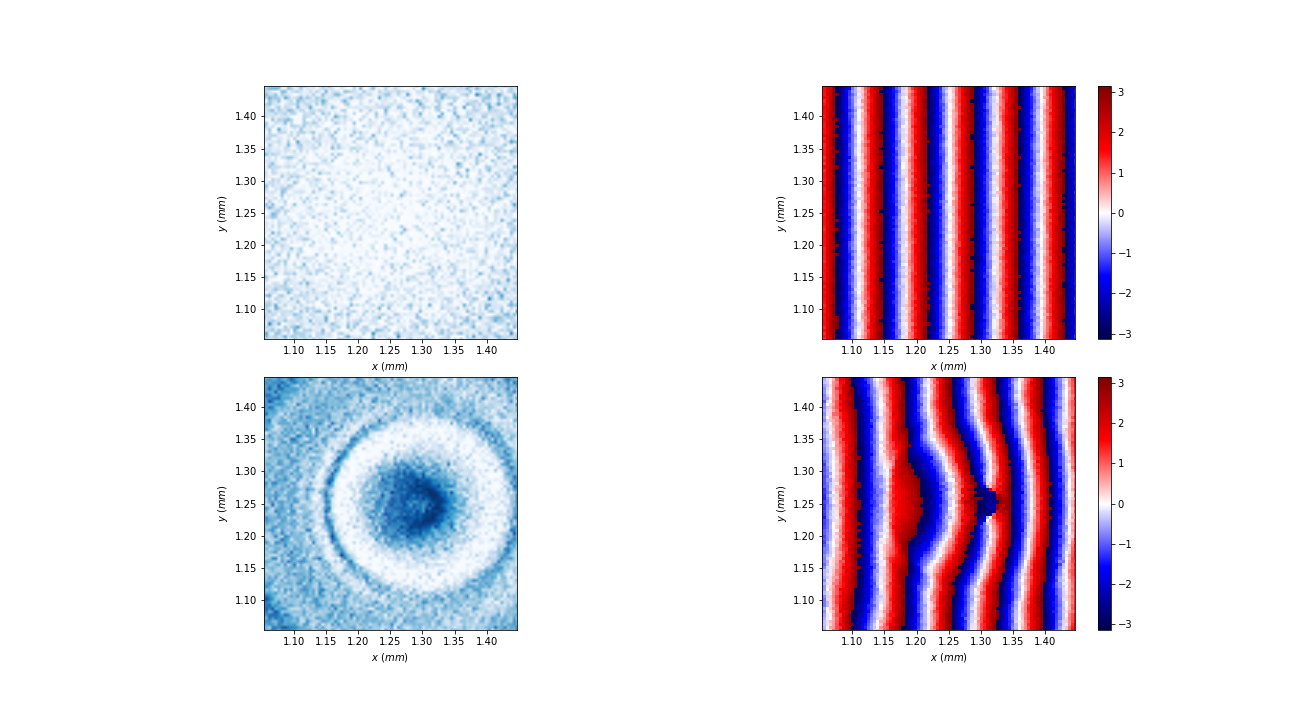

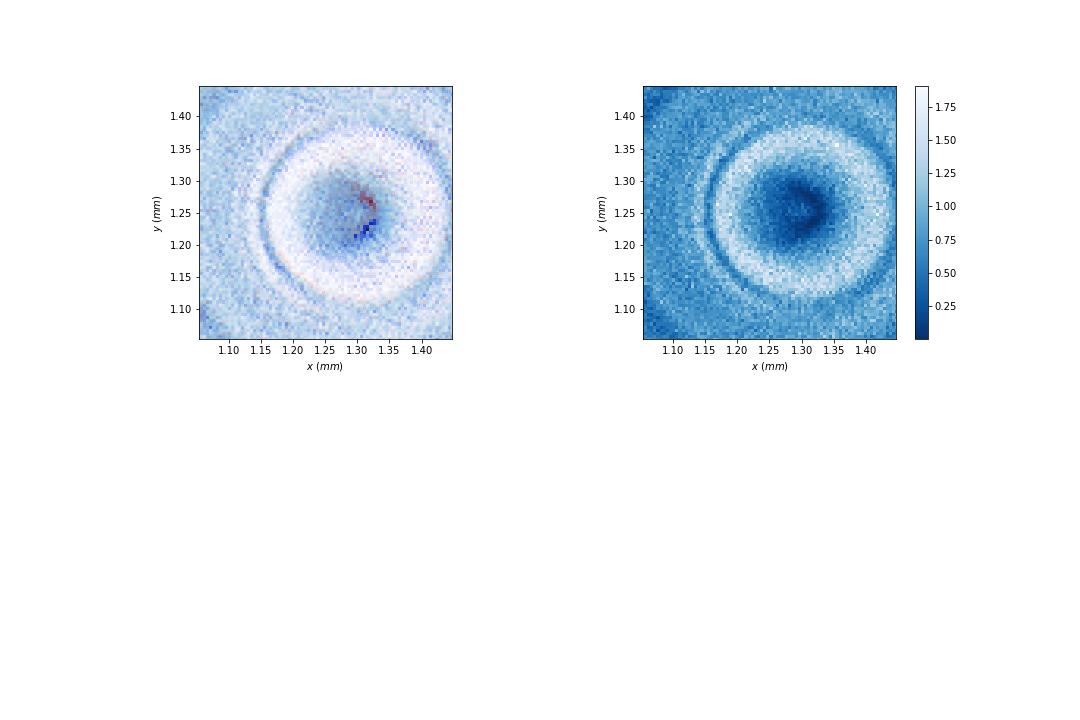

In [64]:
%matplotlib widget
#%matplotlib inline

x_center = my_mesh.lx/factor_t/(1e-3)/2.0
y_center = my_mesh.ly/factor_t/(1e-3)/2.0

width_arround_defect = 50
width_arround_defect = width_arround_defect/factor_t/(1e-3)

fig = plt.figure(figsize=(18, 10))

rows = 2
columns = 2

grid = plt.GridSpec(rows, columns, wspace = .2, hspace = .15)

extent_general = [0, my_mesh.lx/factor_t/(1e-3),0,my_mesh.ly/factor_t/(1e-3)]

plt.subplot(grid[0, 0])

data_temp = transpose(abs(simulation_data[0])**2)
data_temp = data_temp/np.max(data_temp)
ls = LightSource(azdeg=3155,altdeg=45)
cmap = plt.cm.Blues_r
rgb = ls.shade(data_temp, cmap = cmap, vmin=0., vmax=0.7,)
img = plt.gca().imshow(rgb,interpolation='bilinear', extent = extent_general)

xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
plt.xlim(xmin = x_center - width_arround_defect, xmax = x_center + width_arround_defect)
plt.ylim(ymin = y_center - width_arround_defect, ymax = y_center + width_arround_defect)

plt.subplot(grid[0, 1])
phase = np.arctan2(np.imag(simulation_data[0]), np.real(simulation_data[0]))
im = imshow(transpose(phase), origin = "lower", extent = extent_general, 
       aspect = "equal", cmap = 'seismic')
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
colorbar(im)
plt.xlim(xmin = x_center - width_arround_defect, xmax = x_center + width_arround_defect)
plt.ylim(ymin = y_center - width_arround_defect, ymax = y_center + width_arround_defect)

plt.subplot(grid[1, 0])
data_temp = transpose(abs(simulation_data[-1])**2)
data_temp = data_temp/np.max(data_temp)
ls = LightSource(azdeg=3155,altdeg=45)
cmap = plt.cm.Blues_r
rgb = ls.shade(data_temp, cmap = cmap, vmin=0., vmax=0.7,)
img = plt.gca().imshow(rgb,interpolation='bilinear', extent = extent_general)
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
plt.xlim(xmin = x_center - width_arround_defect, xmax = x_center + width_arround_defect)
plt.ylim(ymin = y_center - width_arround_defect, ymax = y_center + width_arround_defect)

plt.subplot(grid[1, 1])
phase = np.arctan2(np.imag(simulation_data[-1]), np.real(simulation_data[-1]))
im = imshow(np.transpose(phase), origin = "lower",extent = extent_general, 
       aspect = "equal", cmap = 'seismic')
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
colorbar(im)
plt.xlim(xmin = x_center - width_arround_defect, xmax = x_center + width_arround_defect)
plt.ylim(ymin = y_center - width_arround_defect, ymax = y_center + width_arround_defect)

fig = plt.figure(figsize=(15, 10))

rows = 1
columns = 2

plt.subplot(grid[0, 0])
data_temp = transpose(abs(simulation_data[-1])**2)
data_temp = data_temp/np.max(data_temp)
ls = LightSource(azdeg=3155,altdeg=45)
cmap = plt.cm.Blues_r
rgb = ls.shade(data_temp, cmap = cmap, vmin=0., vmax=0.7,)
img = plt.gca().imshow(rgb,interpolation='bilinear', extent = extent_general)

vorticity = get_vorticity(np.transpose(simulation_data[-1]), my_mesh.dx, my_mesh.dy)

plt.imshow(vorticity, cmap="seismic", extent = extent_general, 
       aspect = "equal", alpha=0.5)

xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")

plt.xlim(xmin = x_center - width_arround_defect, xmax = x_center + width_arround_defect)
plt.ylim(ymin = y_center - width_arround_defect, ymax = y_center + width_arround_defect)

plt.subplot(grid[0, 1])
im = imshow(transpose(abs(simulation_data[-1])**2), origin = "lower", extent = extent_general, 
       aspect = "equal", cmap = 'Blues_r')
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
colorbar(im)

XX, YY = np.meshgrid(np.linspace(0, extent_general[1], x_shape), np.linspace(0, extent_general[-1], y_shape))
px, py = get_momentum_vector_2d(np.transpose(simulation_data[-1]), my_mesh.dx/factor_t, my_mesh.dy/factor_t)

arrays = np.where( ((XX>=(x_center - width_arround_defect))&(XX<=(x_center + width_arround_defect)))&
                   ((YY>=(y_center - width_arround_defect))&(YY<=(y_center + width_arround_defect))) )


XX_cutted = XX[arrays]
YY_cutted = YY[arrays]
px_cutted = px[arrays]
py_cutted = py[arrays]

shape = int(np.sqrt(np.shape(XX_cutted)[0]))

XX_cutted = np.reshape(XX_cutted,(shape, shape))
YY_cutted = np.reshape(YY_cutted,(shape, shape))
px_cutted = np.reshape(px_cutted,(shape, shape))
py_cutted = np.reshape(py_cutted,(shape, shape))

#plt.streamplot(XX_cutted, YY_cutted, px_cutted, py_cutted, color="k", linewidth=0.6, density=4, arrowsize=0.5)

plt.xlim(xmin = x_center - width_arround_defect, xmax = x_center + width_arround_defect)
plt.ylim(ymin = y_center - width_arround_defect, ymax = y_center + width_arround_defect)

plt.xlim(xmin = x_center - width_arround_defect, xmax = x_center + width_arround_defect)
plt.ylim(ymin = y_center - width_arround_defect, ymax = y_center + width_arround_defect)

fig.tight_layout()

In [68]:
jn(0,0)

1.0

# <font color='blue'>Plot incompressible kinetic energy</font>

In [127]:
k_collection = []
E_incom_collection = []

manager = enlighten.get_manager()
ticks = manager.counter(total=len(simulation_data), desc="Calculating data", unit="it", color="blue")

for i in range(len(simulation_data)):

    r_temp, Eci_temp, ecc_temp = get_field_turbulence_properties_single_field(np.transpose(simulation_data[i]), my_mesh.dx/factor_t, my_mesh.dx/factor_t, k_n=128)
    
    k_collection.append(r_temp[1:])
    E_incom_collection.append(Eci_temp[1:])
    
    ticks.update()
        
manager.stop()

KeyboardInterrupt: 

In [ ]:
plt.figure()
for i in range(len(simulation_data)):
    plt.plot(k_collection[i], E_incom_collection[i])
    
plt.axvline(x=2.0*np.pi/(width_arround_defect*1e-3))  
    
plt.xscale("log")
plt.yscale("log")

In [152]:
c = np.linspace(-5, 5, 512)
ddx = c[1] - c[0]
xxx, yyy = np.meshgrid(c, c)

wx = 2.0
wy = wx
f = np.exp(-xxx**2.0/wx**2.0-yyy**2.0/wx**2.0)

I = f**2.0

print(np.sum(I)*ddx*ddx)
print(0.5*np.pi*wx**2.0)

6.283178462490346
6.283185307179586
